In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys, os

sys.path.insert(0, os.path.abspath('..'))

import jax
import jax.numpy as jnp

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True) # since we are on cpu we do not mind using 64 bits

from LombScargle import periodogram



In [25]:


def randomized_period(y):
    """null template with randomized period"""
    
    def get_periods(freq, total_time):
        """Convert the y to the periods of cycles.
            cycles is a float = freq * total time"""
        cycles= freq * total_time
        cycles_frac, _cycles_integer = jnp.modf(cycles)
        cycles_integer = _cycles_integer.astype(int)

        weights = (jnp.arange(1, len(y)+1) <= cycles).astype(float)  
        weights = weights.at[cycles_integer].set(cycles_frac)
        return total_time * y / jnp.sum(y * weights)


    def temp(_t, freq):
        t = _t - jnp.min(_t)
        periods = get_periods(freq, jnp.max(t)) 
        grid = jnp.cumsum(periods)
        grid_paddled = jnp.insert(grid, 0, 0.)
        which_period = jnp.searchsorted(grid, t)
        x = (t - grid_paddled[which_period]) / periods[which_period]
        return jnp.sin(2 * jnp.pi * x), jnp.cos(2 * jnp.pi * x), periods
    
    return temp


In [35]:
def Pi(start, width, text):
    plt.arrow(start, 0, width, 0, color = 'black', head_width = 0.05, head_length = 0.05, length_includes_head = True)
    plt.arrow(start + width, 0, -width, 0, color = 'black', head_width = 0.05, head_length = 0.05, length_includes_head = True) # to make the arrow heads on both sides
    plt.text(start + width * 0.5, 0.07, text, horizontalalignment='center', fontsize = ff)
    
    
def all_Pi(periods):
    
    start = 0.
    for i in range(len(periods)):
        Pi(start, periods[i], r'$P_{0}$'.format(i + 1))
        start += periods[i]

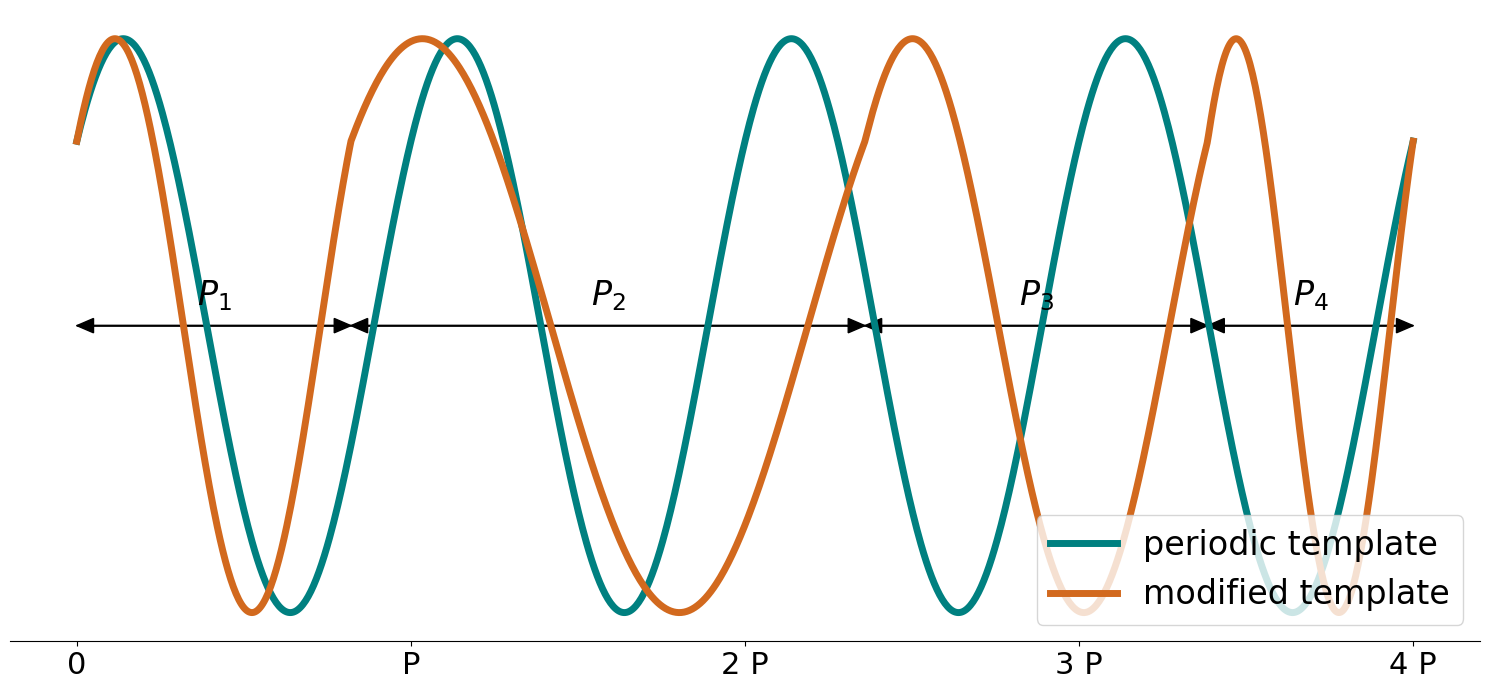

In [40]:
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

fig, ax = plt.subplots(figsize = (15, 7))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['0', 'P', '2 P', '3 P', '4 P'])

t = jnp.linspace(0, 4, 1000)
phi = 40. * jnp.pi / 180.
a1, a2 = jnp.cos(phi), jnp.sin(phi)

sin, cos = jnp.sin(2 * jnp.pi * t), jnp.cos(2 * jnp.pi * t)
plt.plot(t, a1*sin + a2*cos, label = 'periodic template', color = 'teal', lw = 5)
sin, cos, periods = randomized_period(jnp.array([0.8, 1.5, 1, 0.6]))(t, 1.)
plt.plot(t, a1*sin + a2 * cos, label = 'modified template', color = 'chocolate', lw = 5)
all_Pi(periods)

#plt.xlabel('time', fontsize = ff)
#plt.ylabel('flux', fontsize = ff)
plt.legend(loc = 4, fontsize = ff)
#plt.xlim(0, 4.6)
#plt.ylim(-1.05, 0.18)
plt.tight_layout()
plt.savefig('../img/template.png')
plt.show()